### (IN PROGRESS)

# Fracking and Oklahoma Quakes analysis

In this analysis, I will be looking at the dataset [Oklahoma Earthquakes and Saltwater Injection Wells](https://www.kaggle.com/ksuchris2000/oklahoma-earthquakes-and-saltwater-injection-wells) to see if I can find any correlation between the earthquakes and the use of [Injection Wells](https://en.wikipedia.org/wiki/Injection_well)

### Preface

In [1]:
from datetime import datetime
import pandas as pd

http://www.ogs.ou.edu/pubsscanned/openfile/OF1_2014_Murray.pdf

### Preprocessing

Preprocessing the data consists of removing unneeded rows and columns relating to the location of the well/quake as well as adding a python Datetime object as an attribute for the date of the event.

In [5]:
from scripts import preprocess
wells = preprocess.preprocess_wells()
quakes = preprocess.preprocess_quakes()

ModuleNotFoundError: No module named 'pandas'

In [3]:
quakes

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,horizontalError,depthError,magError,magNst,status,locationSource,magSource,year,months,days
0,1973-03-17,36.0870,-106.168000,6.00,4.50,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,reviewed,us,us,1973,03,17
1,1973-05-25,33.9170,-90.775000,6.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,reviewed,s,us,1973,05,25
2,1973-09-19,37.1600,-104.594000,5.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,reviewed,us,us,1973,09,19
3,1973-09-23,37.1480,-104.571000,5.00,4.20,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,reviewed,us,us,1973,09,23
4,1974-02-15,36.5000,-100.693000,24.00,4.50,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,reviewed,us,us,1974,02,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13949,2016-09-20,37.2730,-98.069167,5.09,2.19,ml,13.0,238.0,0.04743,0.04,...,0.36,0.49,0.116,18.0,reviewed,ismp,ismp,2016,09,20
13950,2016-09-20,36.4372,-96.900800,6.05,2.20,ml,NaN,71.0,0.00400,0.32,...,0.70,1.70,0.062,34.0,reviewed,us,us,2016,09,20
13951,2016-09-20,36.4360,-96.906200,4.50,2.40,ml,NaN,66.0,0.00100,0.20,...,0.80,1.30,0.055,43.0,reviewed,us,us,2016,09,20
13952,2016-09-20,37.2750,-98.071833,5.29,2.28,ml,15.0,235.0,0.04962,0.05,...,0.33,0.41,0.188,18.0,reviewed,ismp,ismp,2016,09,20


In [5]:
wells

,Operator,WellType,WellNumber,OrderNumbers,Approval Date,County,LAT,LONG,PSI,BBLS,ZONE,year,month,day,time,well_count
0,XTO ENERGY INC,2R,1103,3.068040e+05,12/18/1936,CARTER,34.199067,-97.399092,"1,100","3,500","HEWITT (HOXBAR, DEESE)",1936,12,18,1936-12-18,1
1,GATEWAY RESOURCES USA INC,2R,3-W,3.231000e+04,4/22/1945,WASHINGTON,36.901903,-95.900888,NaN,NaN,WAYSIDE,1945,4,22,1945-04-22,2
2,WHITE MONTY & TERRY PRODUCTION,2D,1,1.939300e+04,10/19/1946,LINCOLN,35.511472,-96.767417,0,100,UNKNOWN FORMATION,1946,10,19,1946-10-19,1
3,CIRCLE 9 RESOURCES LLC,2R,43,1.985200e+04,3/18/1947,PAWNEE,36.167568,-96.722799,NaN,NaN,BARTLESVILLE,1947,3,18,1947-03-18,3
4,CIRCLE 9 RESOURCES LLC,2R,37,1.985200e+04,3/18/1947,PAWNEE,36.164978,-96.717249,NaN,NaN,BARTLESVILLE,1947,3,18,1947-03-18,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11060,BROWER OIL & GAS CO INC,2D,3A,1.801460e+09,8/30/2017,OKMULGEE,35.475614,-95.911700,400,500,BOOCH,2017,8,30,2017-08-30,3986
11061,COMPLETE ENERGY SERVICES INC,CDW,1,1.701070e+10,8/30/2017,DEWEY,36.146649,-98.934932,"1,635","5,000","BROWN DOLOMITE, CHASE, COUNCIL GROVE",2017,8,30,2017-08-30,367
11062,URBAN OIL & GAS GROUP LLC,2R,5,1.710300e+09,8/30/2017,MCCLAIN,34.919795,-97.421550,"3,500",500,"HUNTON, VIOLA",2017,8,30,2017-08-30,6664
11063,CITATION OIL & GAS CORPORATION,2R,142,1.709600e+09,8/30/2017,CARTER,34.373645,-97.399878,"1,500",999,PENNSYLVANIA SAND (DEESE),2017,8,30,2017-08-30,6665


In [9]:
import matplotlib.pyplot as plt

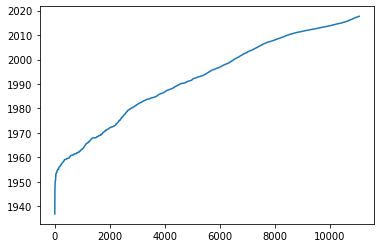

In [11]:
fig, ax = plt.subplots()
ax.plot(wells['time'])

## A quick look

First, I want to take a look at the total number of wells over time and the amount of earthquakes over time.

In [7]:
#wells_plot = alt.Chart(wells.reset_index()).mark_area().encode(
#    x='time:T',
#    y='index',
#).properties(width=800, title='Wells')

# wells_plot = alt.Chart(wells.reset_index()).mark_area().encode(
#     x='time:T',
#     y='index',
# ).properties(width=800, title='Wells')
#
# quakes_plot = alt.Chart(quakes.reset_index()).mark_bar().encode(
#     x='time:T',
#     y='count()'
# ).properties(width=800, height=200, title='Quakes')

# wells_plot & quakes_plot

alt.VConcatChart(...)

## Mapping

Now let's take a look at where the wells are, and where the quakes are on a map.

In [4]:
#states_url = 'https://raw.githubusercontent.com/deldersveld/topojson/master/countries/united-states/us-albers.json'

#states = alt.topo_feature(url=states_url, feature='us')

# states_url = 'https://raw.githubusercontent.com/kylepollina/Fracking_and_Oklahoma_Quakes/master/states.json'
# states = alt.topo_feature(url=states_url, feature='us')

# statemap = alt.Chart(states).mark_geoshape(
#     fill = 'lightgrey',
#     stroke = 'white'
# ).properties(
#     width = 800,
#     height = 400
# )
#

In [5]:
# # quake_points = alt.Chart(quakes).mark_circle().encode(
# #     latitude = 'latitude',
# #     longitude = 'longitude'
# # )
# #
# well_points = alt.Chart(wells.reset_index()).mark_circle().encode(
#     latitude = 'LAT',
#     longitude = 'LONG',
#     color = alt.value('red'),
# ).properties(width=1000,height=500)
#
# statemap + quake_points + well_points
#

alt.LayerChart(...)

As you can see, the well data focuses mainly on wells within Oklahoma. There are a lot of wells here. 

## Looking at the Wells

Looking at the wells data, there are 5 different types of wells. Lets see if they look to have any correlation with the number of earthquakes.

In [6]:
# # well_type_plot = alt.Chart(wells).mark_line().encode(
# #     x='time:T',
# #     y='well_count:Q',
# #     color='WellType:N'
# # )
# #
# (well_type_plot + quakes_plot).properties(width=800, height=400) & quakes_plot
#

alt.VConcatChart(...)

In [7]:
# alt.Chart(wells).mark_bar().encode(
#     x='time:T',
#     y='count()',
# ).properties(width=800, height=500).interactive()
#

alt.Chart(...)